In [7]:
!pip install timm

In [8]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torchvision
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [9]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    download = True,
    train = True,
    transform = transforms.Compose([
        transforms.Resize(73), 
        transforms.ToTensor(),]))
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    download=True,
    train=False,
    transform = transforms.Compose([
        transforms.Resize(73), 
        transforms.ToTensor(),]))

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [15]:
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        self.model = timm.create_model('inception_v3', pretrained=False)

        self.model.Conv2d_1a_3x3.conv = nn.Conv2d(in_channels, 32, kernel_size=3)
    
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

model = Model()
model = model.to(device)

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 2

In [18]:
def train():
    loss = 0
    for j,(images,targets) in enumerate(tqdm(train_dataloader)):
        images, targets = images.to(device), targets.to(device)

        y_pred = model(images)

        loss = criterion(y_pred,targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
    test_loss /= len(test_dataloader)
    return test_loss

def predict(dataloader):
    pred_list = []

    for X, y in tqdm(dataloader):
        X = X.to(device)
        pred = model(X)
        pred = pred.detach().cpu()

        for i in range(len(y)):
            pred_list.append((pred[i], y[i]))
    
    return pred_list

In [17]:
losses_train = []
losses_test = []

for i in range(epochs):
    print(f"Epoch {i+1}")
    loss_train = train()
    losses_train.append(loss_train)
    loss_test = test()
    losses_test.append(loss_test)
    print(f"\nLoss train: {loss_train}, Loss test: {loss_test}")

Epoch 1


100%|██████████| 157/157 [00:25<00:00,  6.28it/s]



Loss train: 1.6590207815170288, Loss test: 1.6546846909128177
Epoch 2


100%|██████████| 157/157 [00:25<00:00,  6.28it/s]


Loss train: 0.7890465259552002, Loss test: 0.8123162631775923


In [19]:
x_test_features = predict(test_dataloader)

100%|██████████| 157/157 [00:27<00:00,  5.81it/s]


In [20]:
test_features = [el[0].numpy() for el in x_test_features]

In [21]:
label_test =  [el[1].item() for el in x_test_features]

In [22]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 1.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.447019
[t-SNE] Computed conditional probabilities in 1.093s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 71.9329300, gradient norm = 0.0022627 (50 iterations in 12.138s)
[t-SNE] Iteration 100: error = 72.1672287, gradient norm = 0.0020483 (50 iterations in 17.419s)
[t-SNE] Iteration 150: error = 72.4403915, gradient norm = 0.0007890 (50 iterations in 11.671s)
[t-SNE] Iteration 200: error = 72.5886078, gradient norm = 0.0006297 (50 iterations in 9.836s)
[t-SNE] Iteration 250: error = 72.6535645, gradient norm = 0.0007892 (50 iterations in 6.813s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.653564
[t-SNE] Iteration 300: error = 2.4910986, gradient norm = 0.0010492 (50 iterations in 6.365s)
[t-SNE] Iteration 350: error = 2.1524916, gradient norm = 0.0005053 (50 iterations in 5.425s)
[t-SNE] Iteration 400: error = 1.9679673, gradient norm = 0.0003198 (50 iterations in 5.078s)
[t-SNE] Iteration 450: error = 1.8479031, gradient norm = 0.0002260 (50 iterations in 4.854s)
[t-SNE] Iteration 500: error = 1.7652347, gradient norm = 0.0001684 (

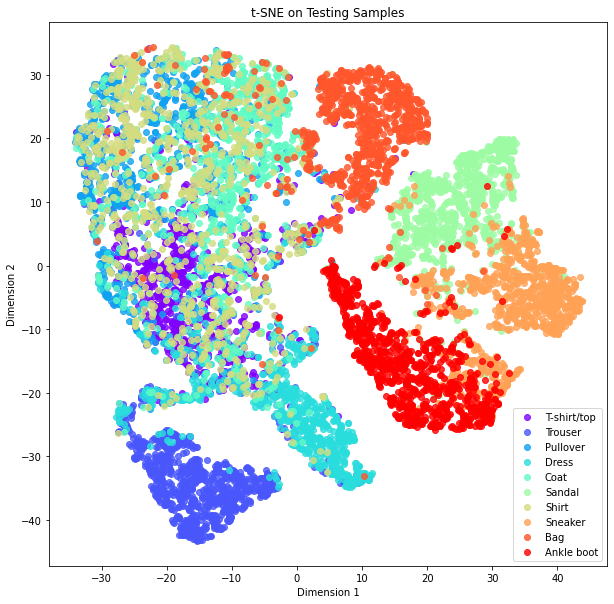

In [25]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(np.array(label_test)  == c_group), 0],
                tsne_features[np.where(np.array(label_test) == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show()